# Physical modeling

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

## Diffusion

Before we get to a Reaction-Diffusion model, we'll start with simple diffusion.

The kernel computes the difference between each cell and the sum of its neighbors.

At each time step, we compute this difference, multiply by a constant, and add it back in to the array.

In [2]:
from scipy.signal import correlate2d
from Cell2D import Cell2D, draw_array


class Diffusion(Cell2D):
    """Diffusion Cellular Automaton."""
    
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])

    def __init__(self, n, r=0.1):
        """Initializes the attributes.

        n: number of rows
        r: diffusion rate constant
        """
        self.r = r
        self.array = np.zeros((n, n), np.float)
        
    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        self.array += self.r * c
        
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Reds')

Here's a simple example starting with an "island" of material in the middle.

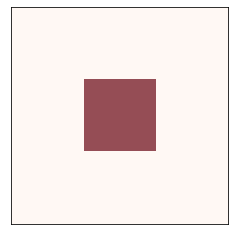

In [3]:
diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
diff.draw()

And here's how it behaves over time: the "material" spreads out until the level is equal on the whole array.

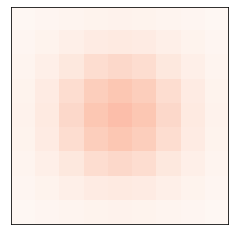

In [4]:
diff.animate(frames=20, interval=0.1)

Saving figure to file figs/chap07-1


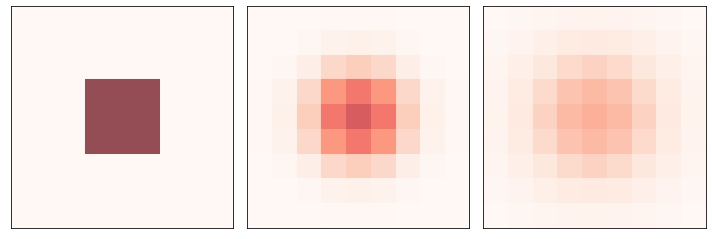

In [5]:
from utils import three_frame

diff = Diffusion(n=9, r=0.1)
diff.add_cells(3, 3, '111', '111', '111')
three_frame(diff, [0, 5, 10])

savefig('figs/chap07-1')

## Reaction-Diffusion

Now we'll add a second material and let them interact.

The following function helps with setting up the initial conditions.

In [6]:
def add_island(a, height=0.1):
    """Adds an island in the middle of the array.
            
    height: height of the island
    """
    n, m = a.shape
    radius = min(n, m) // 20
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] += height

For the RD model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

In [7]:
class ReactionDiffusion(Diffusion):
    """Reaction-Diffusion Cellular Automaton."""

    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, params, noise=0.1):
        """Initializes the attributes.

        n: number of rows
        params: tuple of (Da, Db, f, k)
        """        
        self.params = params
        self.array1 = np.ones((n, n), dtype=float)
        self.array2 = noise * np.random.random((n, n))
        add_island(self.array2)
        
    def step(self):
        """Executes one time step."""
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params

        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        self.array1 += ra * cA - reaction + f * (1-A) 
        self.array2 += rb * cB + reaction - (f+k) * B
        
    def loop100(self):
        self.loop(100)
        
    def draw(self):
        """Draws the cells."""
        options = dict(interpolation='bicubic', 
                       vmin=None, vmax=None)
        draw_array(self.array1, cmap='Reds', **options)
        draw_array(self.array2, cmap='Blues', **options)

The viewer for the CA shows both arrays with some transparency, so we can see where one, the other, or both, levels are high.

Unlike previous CAs, the state of each cell is meant to represent a continuous quantity, so it is appropriate to interpolate.

Note that `draw` has to make copies of the arrays because `step` updates the arrays in place.

Here's an example using `params3`, which yields blue dots that seem to undergo mitosis.

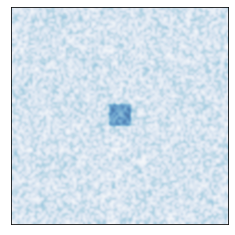

In [10]:
params1 = 0.5, 0.25, 0.035, 0.057   # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd = ReactionDiffusion(n=100, params=params1)
rd.draw()

Here's a random starting condition with lots of A, a sprinkling of B everywhere, and an island of B in the middle.

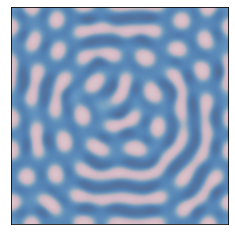

In [11]:
rd.animate(frames=50, step=rd.loop100)

I'll use the following function to generate figures using different parameters.

In [12]:
def make_rd(f, k, n=100):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(n, params)
    return rd

The following parameters yield pink stripes and spots on a blue background:

Saving figure to file figs/chap07-2


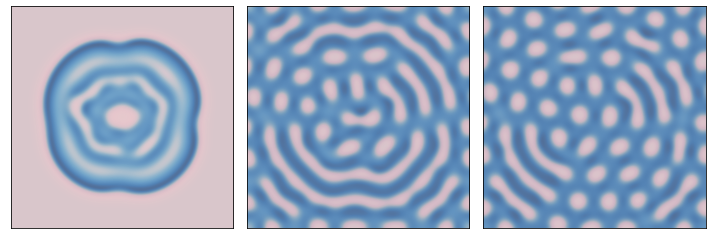

In [13]:
from utils import three_frame

def plot_rd(f, k, filename):
    """Makes a ReactionDiffusion object with given parameters.
    """
    params = 0.5, 0.25, f, k
    rd = ReactionDiffusion(100, params)

    three_frame(rd, [1000, 2000, 4000])
    
    savefig(filename)
    
plot_rd(0.035, 0.057, 'figs/chap07-2')

The following parameters yield blue stripes on a pink background.

Saving figure to file figs/chap07-3


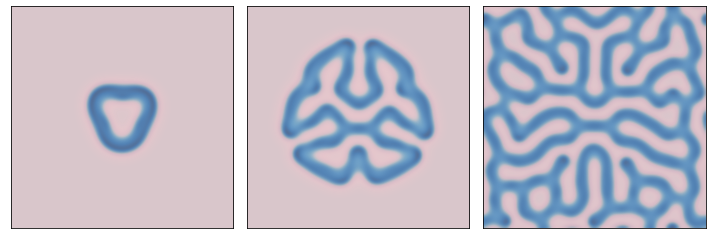

In [14]:
plot_rd(0.055, 0.062, 'figs/chap07-3')

The following parameters yield blue dots on a pink background

Saving figure to file figs/chap07-4


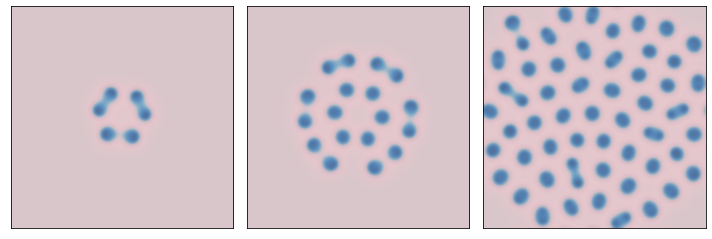

In [15]:
plot_rd(0.039, 0.065, 'figs/chap07-4')

## Percolation

In the percolation model, each cell is porous with probability `p`.  We start with a row of wet cells at the time.  During each time step, a cell becomes wet if it is porous and at least one neighbor is wet (using a 4-cell neighborhood).  For each value of `p` we compute the probability that water reaches the bottom row.

Porous cells have state `1` and wet cells have state `5`, so if a cell has a wet neighbor, the sum of the neighbors will by `5` or more.


In [16]:
from scipy.signal import correlate2d
from Cell2D import Cell2D


class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, q=0.5):
        """Initializes the attributes.

        n: number of rows
        q: probability of porousness
        """
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])
        
        # fill the top row with wet cells
        self.array[0] = 5

    def step(self):
        """Executes one time step."""
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    
    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='Blues', vmax=5)

Here an example that shows the first three time steps.

Saving figure to file figs/chap07-5


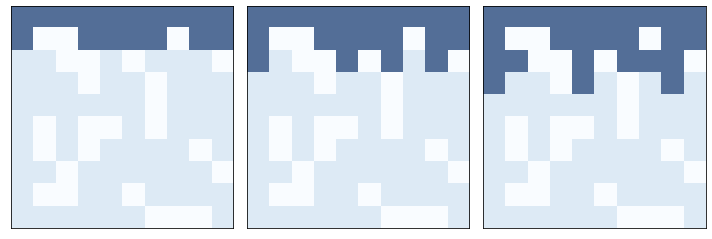

In [17]:
n = 10
q = 0.7
np.random.seed(18)
perc = Percolation(n, q)

three_frame(perc, [1, 1, 1])

savefig('figs/chap07-5')

`test_perc` runs a percolation model and returns `True` if water reaches the bottom row and `False` otherwise.

In [18]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: boolean, whether there's a percolating cluster
    """
    num_wet = perc.num_wet()

    while True:
        perc.step()

        if perc.bottom_row_wet():
            return True
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False

        num_wet = new_num_wet

Run a small example. 

In [19]:
np.random.seed(18)
perc = Percolation(n, q)
test_perc(perc)

True

And here's the animation

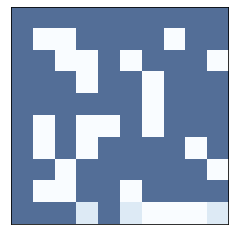

In [20]:
np.random.seed(18)
perc = Percolation(n, q)
perc.animate(frames=12, interval=0.3)

For a given `q` we can estimate the probability of a percolating cluster by running several random configurations.

In [21]:
def estimate_prob_percolating(n=100, q=0.5, iters=100):
    """Estimates the probability of percolating.
    
    n: int number of rows and columns
    q: probability that a cell is permeable
    iters: number of arrays to test
    
    returns: float probability
    """
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

At `q=0.55` the probability is low.

In [22]:
fraction = estimate_prob_percolating(q=0.55)
print(fraction)

0.0


At `q=0.6`, the probability is close to 50%, which suggests that the critical value is nearby.

In [23]:
fraction = estimate_prob_percolating(q=0.6)
print(fraction)

0.71


At `p=0.65` the probability is high.

In [24]:
fraction = estimate_prob_percolating(q=0.65)
print(fraction)

1.0


We can search for the critical value by random walk: if there's a percolating cluster, we decrease `q`; otherwise we increase it.

The path should go to the critical point and wander around it.

In [25]:
def find_critical(n=100, q=0.6, iters=100):
    """Estimate q_crit by random walk.
    
    returns: list of q that should wander around q_crit
    """
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -= 0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

Let's see whether the critical value depends on the size of the grid.

With `n=50`, the random walk wanders around 0.59.

Wall time: 9.35 s


0.5932367632367631

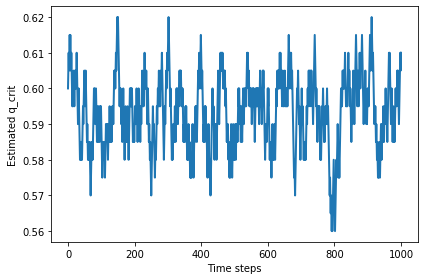

In [26]:
%time qs = find_critical(n=50, iters=1000)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Larger values of `n` don't seem to change the critical value.

Wall time: 13.7 s


0.5933830845771144

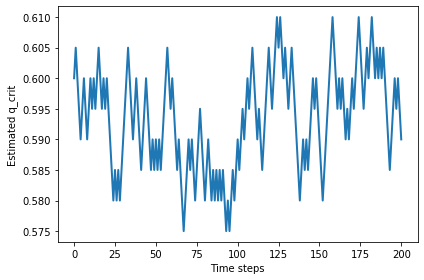

In [27]:
%time qs = find_critical(n=100, iters=200)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Wall time: 23.2 s


0.5912195121951219

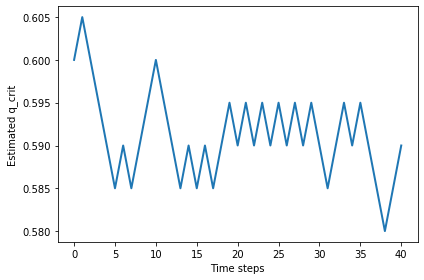

In [28]:
%time qs = find_critical(n=200, iters=40)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

Wall time: 1min


0.5968181818181817

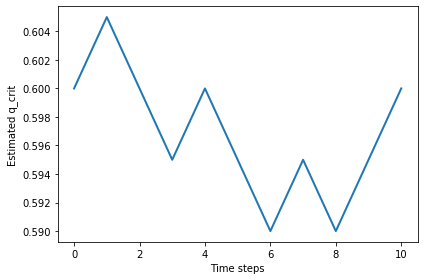

In [29]:
%time qs = find_critical(n=400, iters=10)
plt.plot(qs)
decorate(xlabel='Time steps', ylabel='Estimated q_crit')
np.mean(qs)

## Fractals

Near the critical point, the cluster of wet cells forms a fractal.  We can see that visually in these examples:

False


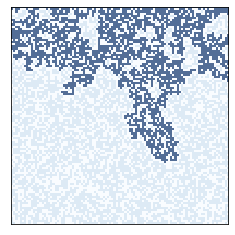

In [30]:
np.random.seed(22)
perc1 = Percolation(n=100, q=0.6)
flag = test_perc(perc1)
print(flag)
perc1.draw()

False


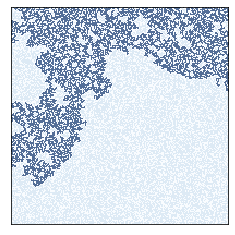

In [31]:
np.random.seed(22)
perc2 = Percolation(n=200, q=0.6)
flag = test_perc(perc2)
print(flag)
perc2.draw()

True


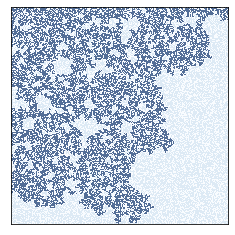

In [32]:
np.random.seed(22)
perc3 = Percolation(n=300, q=0.6)
flag = test_perc(perc3)
print(flag)
perc3.draw()

Saving figure to file figs/chap07-6


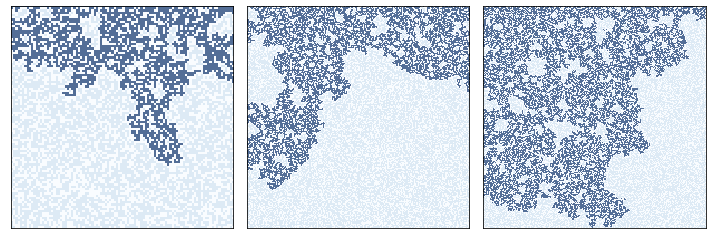

In [33]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
perc1.draw()

plt.subplot(1, 3, 2)
perc2.draw()

plt.subplot(1, 3, 3)
perc3.draw()

plt.tight_layout()
savefig('figs/chap07-6')

To measure fractal dimension, let's start with 1D CAs.

In [34]:
from Cell1D import Cell1D, draw_ca

Here's one rule that seems clearly 1D, one that is clearly 2D, and one that we can't obviously classify.

Saving figure to file figs/chap07-7


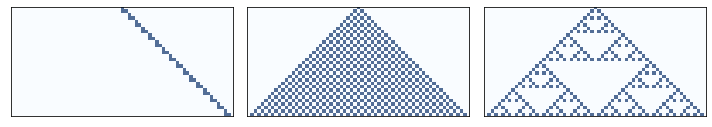

In [35]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
draw_ca(20)

plt.subplot(1, 3, 2)
draw_ca(50)

plt.subplot(1, 3, 3)
draw_ca(18)

plt.tight_layout()
savefig('figs/chap07-7')

The following function creates a 1D CA and steps through time, counting the number of on cells after each time step.

In [36]:
def count_cells(rule, n=500):
    """Create a 1-D CA and count cells.
    
    rule: int rule number
    n: number of steps
    """
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
        
    return res

This function plots the results, comparing the rate of cell growth to `size` and `size**2`.

And it uses linregress to estimate the slope of the line on a log-log scale.

In [37]:
from scipy.stats import linregress

def test_fractal(rule, ylabel='Number of Cells'):
    """Compute the fractal dimension of a rule.
    
    rule: int rule number
    ylabel: string
    """
    res = count_cells(rule)
    steps, steps2, cells = zip(*res)

    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(steps, steps2, label='d=2', **options)
    plt.plot(steps, cells, label='rule=%d' % rule)
    plt.plot(steps, steps, label='d=1', **options)

    decorate(xscale='log', yscale='log',
             xlabel='Time Steps',
             ylabel=ylabel,
             xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

The linear rule has dimension close to 1.

1.0079212645952567


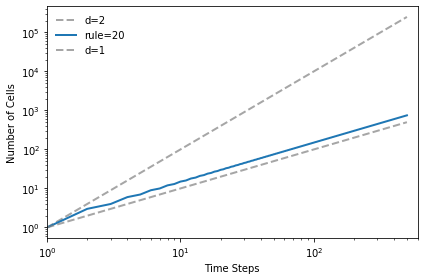

In [38]:
test_fractal(20)

The triangular rule has dimension close to 2.

1.971280883626812


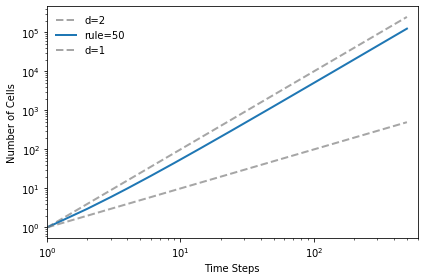

In [39]:
test_fractal(50)

And the Sierpinski triangle has fractal dimension approximately 1.57

1.5739294411777092


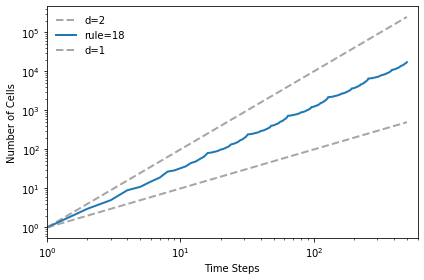

In [40]:
test_fractal(18)

1.0079212645952567
1.971280883626812
1.5739294411777092
Saving figure to file figs/chap07-8


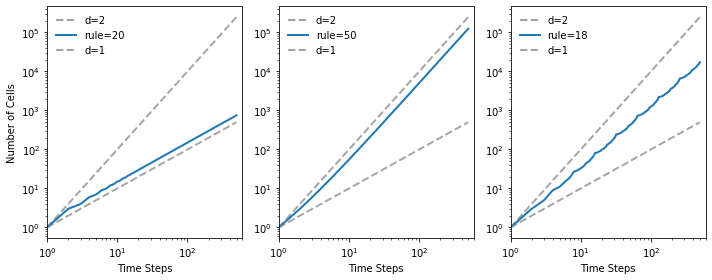

In [41]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
test_fractal(20)

plt.subplot(1, 3, 2)
test_fractal(50, ylabel='')

plt.subplot(1, 3, 3)
test_fractal(18, ylabel='')

savefig('figs/chap07-8')

Mathematically, the fractal dimension is supposed to be:

In [42]:
np.log(3) / np.log(2)

1.5849625007211563

## Fractals in percolation models

We can measure the fractal dimension of a percolation model by measuring how the number of wet cells scales as we increase the size of a bounding box.

The following function takes a percolation model that has run to completion.  It computes bounding boxes with sizes from 10 up to `n-1`, positioned in the center of the array.

For each bounding box it counts the number of wet cells.

In [43]:
from scipy.stats import linregress

def plot_perc_scaling(sizes, q):
    res = []
    for size in sizes:
        perc = Percolation(size, q)
        if test_perc(perc):
            num_filled = perc.num_wet() - size
            res.append((size, size**2, num_filled))
        
    sizes, cells, filled = zip(*res)
    
    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(sizes, cells, label='d=2', **options)
    plt.plot(sizes, filled, '.', label='filled')
    plt.plot(sizes, sizes, label='d=1', **options)
    
    decorate(xlabel='Array Size',
                     ylabel='Cell Count',
                     xscale='log', xlim=[9, 110], 
                     yscale='log', ylim=[9, 20000],
                     loc='upper left')
    
    for ys in [cells, filled, sizes]:
        params = linregress(np.log(sizes), np.log(ys))
        print(params[0])

If we plot the number of cells versus the size of the box on a log-log scale, the slope is the fractal dimension.

When `q` is near the critical point, the fractal dimension of the wet cells is usually between 1.8 and 2.0, but it varies from one run to the next.

2.0
1.9603549799703472
1.0
Saving figure to file figs/chap07-9


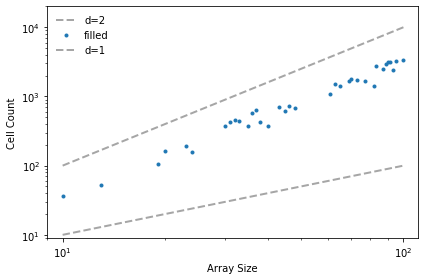

In [44]:
sizes = np.arange(10, 101)
plot_perc_scaling(sizes, q=0.59)

savefig('figs/chap07-9')

**Exercise:** In Chapter 7 we showed that the Rule 18 CA produces a fractal.
Can you find other rules that produce fractals?  For each one,
estimate its fractal dimension.

Note: the `Cell1D` object in `Cell1D.py` does not wrap around from the left edge to the right, which creates some artifacts at the boundaries.  You might want to use `Wrap1D`, which is a child class of `Cell1D` that wraps around.  It is also defined in `Cell1D.py`.

1.5739294411777092
1.6919816307815885


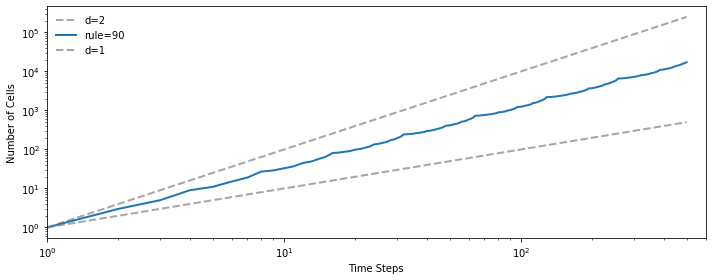

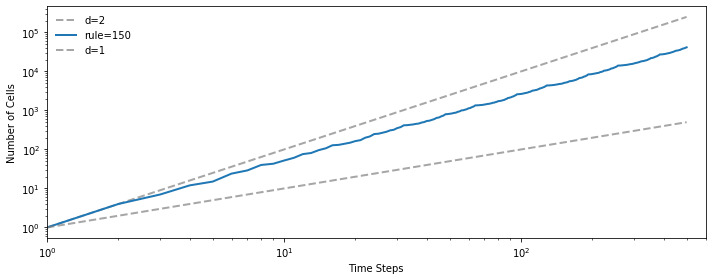

In [54]:
# Solution goes here
plt.figure(figsize=(10, 4))
test_fractal(90)  # Fractal dimension ~1.57

plt.figure(figsize=(10, 4))
test_fractal(150)  # Fractal dimension ~1.69

In [44]:
# Solution goes here

In [45]:
# Solution goes here

In [46]:
# Solution goes here

In [47]:
# Solution goes here

In [48]:
# Solution goes here

**Exercise:** In 1990 Bak, Chen and Tang proposed a cellular automaton that is
an abstract model of a forest fire.  Each cell is in one of three
states: empty, occupied by a tree, or on fire.

The rules of the CA are:

* An empty cell becomes occupied with probability $p$.

* A cell with a tree burns if any of its neighbors
  is on fire.

* A cell with a tree spontaneously burns, with
  probability $f$, even if none of its neighbors is on fire.

* A cell with a burning tree becomes an empty cell in the next
  time step.

Write a
program that implements it.  You might want to inherit from `Cell2D`.
Typical values for the parameters are
$p=0.01$ and $f=0.001$, but you might want to experiment with other
values.

Starting from a random initial condition, run the CA until it reaches
a steady state where the number of trees no longer increases or
decreases consistently.  

In steady state, is the geometry of the forest fractal?
What is its fractal dimension?

In [160]:
# Solution goes here
import random

class ForestFire(Cell2D):
    """Forest Fire Cellular Automaton."""
    
    EMPTY = 0
    TREE = 1
    BURNING = 5
    
    kernel = np.array([[0, 1, 0],
                       [1, 25, 1],
                       [0, 1, 0]])

    
    def key(self, state):
        if state < 25:
            if random.random() < self.p:
                return self.TREE
            return self.EMPTY
        
        if state >= 25 and state < 30:
            if random.random() < self.f:
                return self.BURNING
            return self.TREE
        
        if state >= 30 and state < 125:
            # A neighbor is on fire
            return self.BURNING

        if state >= 125:
            # Self burn
            return self.EMPTY
        

    def __init__(self, n, p = 0.01, f = 0.001):
        """Initializes the attributes.

        n: number of rows
        """
        self.p = p
        self.f = f
        self.array = np.zeros((n, n), np.float)
        
    def add_cells(self, row, col, *strings):
        """Adds cells at the given location.

        row: top row index
        col: left col index
        strings: list of strings of 0s and 1s
        """
        for i, s in enumerate(strings):
            self.array[row+i, col:col+len(s)] = np.array([int(b) for b in s])

    def step(self):
        """Executes one time step."""
        c = correlate2d(self.array, self.kernel, mode='same')
        for y, row in enumerate(c):
            for x, item in enumerate(row):
                self.array[y][x] = self.key(item)
        
    def draw(self):
        """Draws the cells."""
        options = dict(vmin=0, vmax=7)
        cmap = ('White', 'Green', 'Red')
        draw_array(self.array, cmap="rainbow", **options)
        
    def count_num_trees(self):
        count = 0
        for row in self.array:
            for item in row:
                if item == self.TREE:
                    count += 1
        if count == 0:
            count = 1
        return count
        

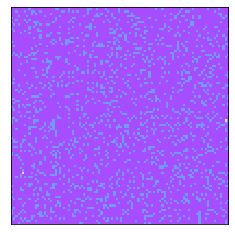

In [161]:
# Solution goes here
fire = ForestFire(n=100)
fire.animate(frames=100, interval=0.05)

In [166]:
# Solution goes here
def test_fire_fractal(n, ylabel='Number of Cells'):
    
    fire = ForestFire(n=n)
    res = []
    for i in range(1, 200):
        cells = fire.count_num_trees()
        res.append((i, i**2, cells))
        fire.step()

    steps, steps2, cells = zip(*res)

    options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(steps, steps2, label='d=2', **options)
    plt.plot(steps, cells)
    plt.plot(steps, steps, label='d=1', **options)

    decorate(xscale='log', yscale='log',
             xlabel='Time Steps',
             ylabel=ylabel,
             xlim=[1, 600], loc='upper left')

    for ys in [cells]:
        params = linregress(np.log(steps), np.log(ys))
        print(params[0])

0.600336326529525


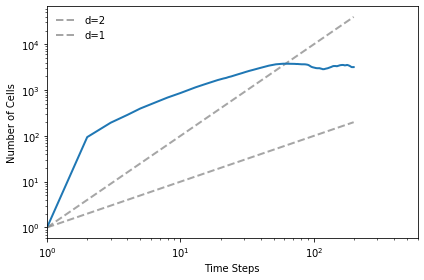

In [167]:
# Solution goes here
test_fire_fractal(100)
# Not sure exactly what to get out of this plot, but it seems to have a slope of somewhere around 1. So maybe it's not fractal?

In [53]:
# Solution goes here

In [58]:
# Solution goes here

In [55]:
# Solution goes here

In [56]:
# Solution goes here